# Auto Encoder

## Load Dataset

In [1]:
DATASET_NAME = 'dataset-5000'
TEST_DATASET_NAME = 'dataset-test'
BATCH_SIZE = 16
MODEL_PATH = 'model/transformer'

import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from util import GeneratedDataset

trainset = GeneratedDataset(DATASET_NAME, transforms.ToTensor())
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = GeneratedDataset(TEST_DATASET_NAME, transforms.ToTensor())
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

## Define Transformer based auto-encoder

- Split 64 * 64 image into 8 * 8 patches (total 8 * 8 = 64 blocks)
- Every block have input length of 8 * 8 * 3 = 192 dimension
- Project the patch into 256 dimension embedding
- Add Positional Encoding to it
- Go through 4 layer of 8 heads transformers with 512 MLP dimension

And the decoder works reversely.

In [2]:
import math

# Define the positional encoding
class PositionalEncoding2D(nn.Module):
    def __init__(self, dim, image_size, patch_size):
        super(PositionalEncoding2D, self).__init__()
        self.encoding = nn.Parameter(self.create_positional_encoding(dim, image_size, patch_size), requires_grad=False)

    def create_positional_encoding(self, dim, image_size, patch_size):
        num_patches = (image_size // patch_size) ** 2
        encoding = torch.zeros(num_patches, dim)
        position = torch.arange(0, num_patches, dtype=torch.float).unsqueeze(1)
        
        # Calculate row and column positions
        row_pos = position // (image_size // patch_size)
        col_pos = position % (image_size // patch_size)
        
        div_term = torch.exp(torch.arange(0, dim, 4).float() * (-math.log(10000.0) / dim))
        
        encoding[:, 0::4] = torch.sin(row_pos * div_term)
        encoding[:, 1::4] = torch.cos(row_pos * div_term)
        encoding[:, 2::4] = torch.sin(col_pos * div_term)
        encoding[:, 3::4] = torch.cos(col_pos * div_term)
        
        return encoding.unsqueeze(0)

    def forward(self, x):
        return x + self.encoding

# Define the Vision Transformer autoencoder model
class TransformerAutoencoder(nn.Module):
    def __init__(self, image_size=64, patch_size=8, dim=512, depth=6, heads=8, mlp_dim=1024, bottleneck_dim=32, dropout_rate=0.1):
        super(TransformerAutoencoder, self).__init__()
        self.patch_size = patch_size
        self.dim = dim
        self.bottleneck_dim = bottleneck_dim
        self.num_patches = (image_size // patch_size) ** 2
        self.flatten_dim = patch_size * patch_size * 3

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim, 
            nhead=heads, 
            batch_first=True,
            dim_feedforward=mlp_dim,
            dropout=dropout_rate
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.patch_embedding = nn.Linear(self.flatten_dim, dim)
        self.positional_encoding = PositionalEncoding2D(dim, image_size, patch_size)
        self.bottleneck = nn.Linear(dim, bottleneck_dim)
        self.decoder_input = nn.Linear(bottleneck_dim, dim)

        # Define the decoder as a transformer encoder
        decoder_layer = nn.TransformerEncoderLayer(
            d_model=dim, 
            nhead=heads, 
            batch_first=True,
            dim_feedforward=mlp_dim,
            dropout=dropout_rate
        )
        self.decoder = nn.TransformerEncoder(decoder_layer, num_layers=depth)

        self.output_layer = nn.Linear(dim, self.flatten_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Divide the image into patches
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        x = x.contiguous().view(x.size(0), -1, self.flatten_dim)

        # Embed patches and add positional encoding
        x = self.patch_embedding(x)
        x = self.positional_encoding(x)

        # Transformer encoding
        x = self.encoder(x)
        encoded = self.bottleneck(x)

        # Transformer decoding
        x = self.decoder_input(encoded)
        x = self.decoder(x)

        # Reshape back to image
        # Output layer to reshape back to image
        x = self.output_layer(x)
        x = self.sigmoid(x)
        x = x.view(x.size(0), 3, 64, 64)
        return x, encoded

In [3]:
from util import train_model_steps, plot_model, count_parameters

def train_model(patch_size=8, dim=256, depth=4, heads=8, mlp_dim=512, embedding_size=32, dropout_rate=0.1, learning_rate=1e-4, weight_decay=1e-5, num_epochs=20):
    # Initialize the model
    model = TransformerAutoencoder(
        patch_size=patch_size,
        dim=dim,
        depth=depth, 
        heads=heads,
        mlp_dim=mlp_dim,
        bottleneck_dim=embedding_size, 
        dropout_rate=dropout_rate
    )
    print(f'Number of parameters: {count_parameters(model)}')

    model, train_losses, test_losses = train_model_steps(model, trainloader, testloader, learning_rate, weight_decay, num_epochs)
    # Save the model
    torch.save(model.state_dict(), f'{MODEL_PATH}/e{embedding_size}p{patch_size}d{dim}dp{depth}h{heads}m{mlp_dim}.pth')
    plot_model(model, train_losses, test_losses, testset)
    return model, train_losses, test_losses


## Evaluation

Testing with embedding size of (down from dim = 512)
- 4
- 8
- 16
- 32
- 64

Number of parameters: 4317892
Epoch [1/20], Train Loss: 0.2734, Test Loss: 0.1970
Epoch [2/20], Train Loss: 0.1815, Test Loss: 0.1688
Epoch [3/20], Train Loss: 0.1647, Test Loss: 0.1579
Epoch [4/20], Train Loss: 0.1288, Test Loss: 0.1167
Epoch [5/20], Train Loss: 0.1112, Test Loss: 0.1081
Epoch [6/20], Train Loss: 0.1050, Test Loss: 0.1025
Epoch [7/20], Train Loss: 0.1013, Test Loss: 0.1010
Epoch [8/20], Train Loss: 0.0993, Test Loss: 0.0985
Epoch [9/20], Train Loss: 0.0974, Test Loss: 0.0965
Epoch [10/20], Train Loss: 0.0959, Test Loss: 0.0970
Epoch [11/20], Train Loss: 0.0946, Test Loss: 0.0943
Epoch [12/20], Train Loss: 0.0935, Test Loss: 0.0934
Epoch [13/20], Train Loss: 0.0928, Test Loss: 0.0927
Epoch [14/20], Train Loss: 0.0921, Test Loss: 0.0919
Epoch [15/20], Train Loss: 0.0914, Test Loss: 0.0915
Epoch [16/20], Train Loss: 0.0911, Test Loss: 0.0910
Epoch [17/20], Train Loss: 0.0907, Test Loss: 0.0907
Epoch [18/20], Train Loss: 0.0905, Test Loss: 0.0905
Epoch [19/20], Train Loss

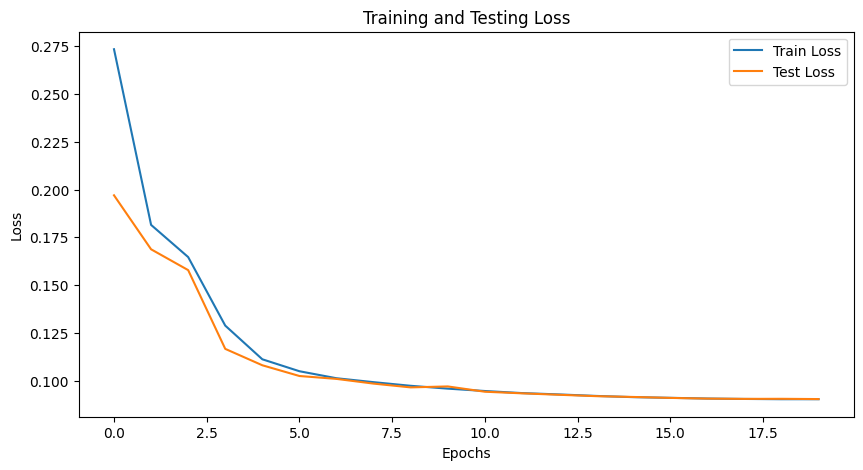

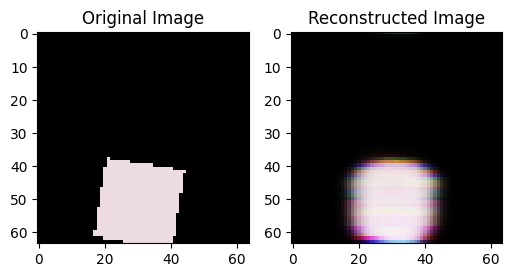

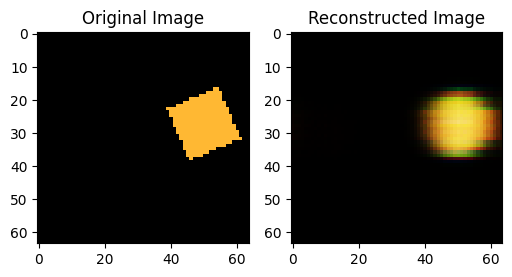

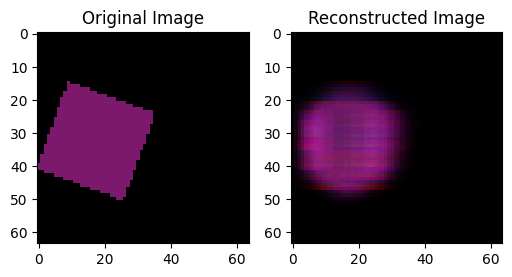

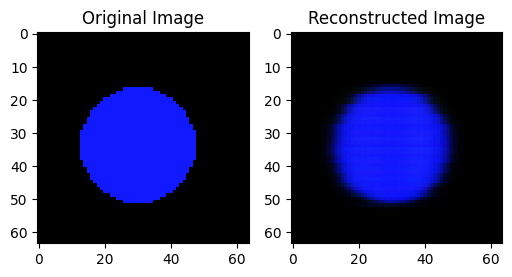

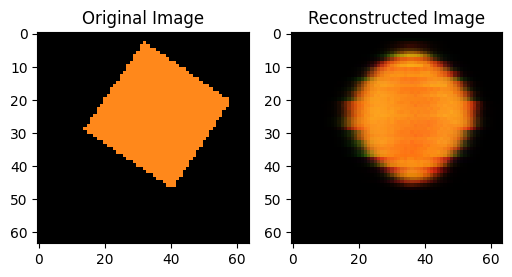

(TransformerAutoencoder(
   (encoder): TransformerEncoder(
     (layers): ModuleList(
       (0-3): 4 x TransformerEncoderLayer(
         (self_attn): MultiheadAttention(
           (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
         )
         (linear1): Linear(in_features=256, out_features=512, bias=True)
         (dropout): Dropout(p=0.1, inplace=False)
         (linear2): Linear(in_features=512, out_features=256, bias=True)
         (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
         (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
         (dropout1): Dropout(p=0.1, inplace=False)
         (dropout2): Dropout(p=0.1, inplace=False)
       )
     )
   )
   (patch_embedding): Linear(in_features=192, out_features=256, bias=True)
   (positional_encoding): PositionalEncoding2D()
   (bottleneck): Linear(in_features=256, out_features=4, bias=True)
   (decoder_input): Linear(in_features=4, out_features=256, bi

In [4]:
train_model(embedding_size=4, dropout_rate=0.1)

Number of parameters: 4317892
Epoch [1/20], Train Loss: 0.2735, Test Loss: 0.1995
Epoch [2/20], Train Loss: 0.1893, Test Loss: 0.1798
Epoch [3/20], Train Loss: 0.1582, Test Loss: 0.1308
Epoch [4/20], Train Loss: 0.1257, Test Loss: 0.1173
Epoch [5/20], Train Loss: 0.1154, Test Loss: 0.1089
Epoch [6/20], Train Loss: 0.1086, Test Loss: 0.1045
Epoch [7/20], Train Loss: 0.1047, Test Loss: 0.1012
Epoch [8/20], Train Loss: 0.1021, Test Loss: 0.0998
Epoch [9/20], Train Loss: 0.1000, Test Loss: 0.0972
Epoch [10/20], Train Loss: 0.0988, Test Loss: 0.0962
Epoch [11/20], Train Loss: 0.0972, Test Loss: 0.0956
Epoch [12/20], Train Loss: 0.0963, Test Loss: 0.0946
Epoch [13/20], Train Loss: 0.0955, Test Loss: 0.0945
Epoch [14/20], Train Loss: 0.0949, Test Loss: 0.0939
Epoch [15/20], Train Loss: 0.0944, Test Loss: 0.0938
Epoch [16/20], Train Loss: 0.0939, Test Loss: 0.0930
Epoch [17/20], Train Loss: 0.0936, Test Loss: 0.0927
Epoch [18/20], Train Loss: 0.0935, Test Loss: 0.0928
Epoch [19/20], Train Loss

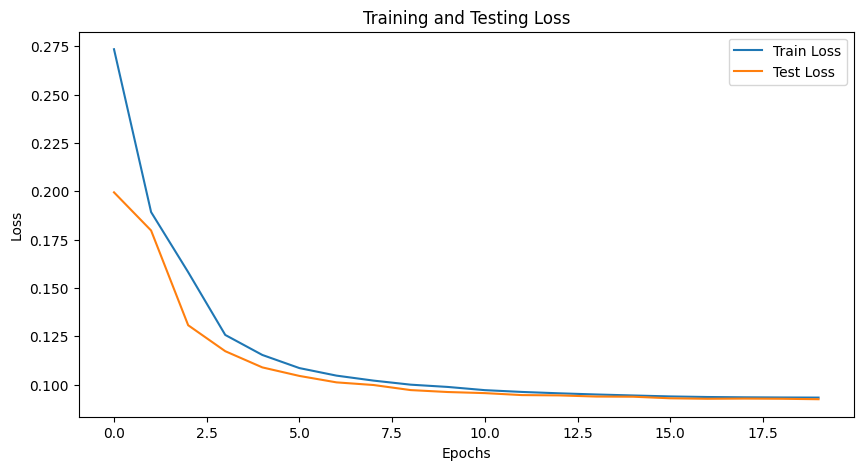

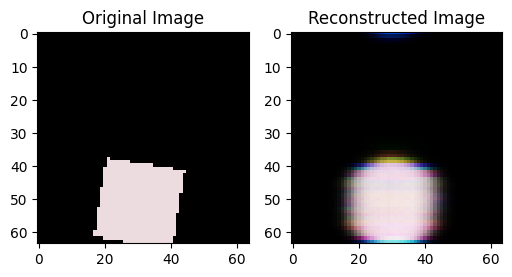

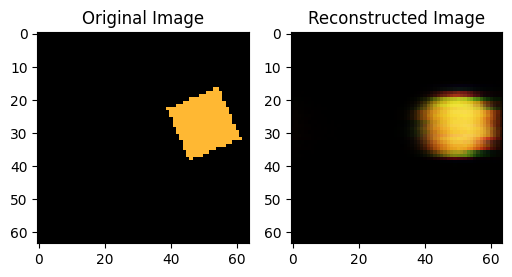

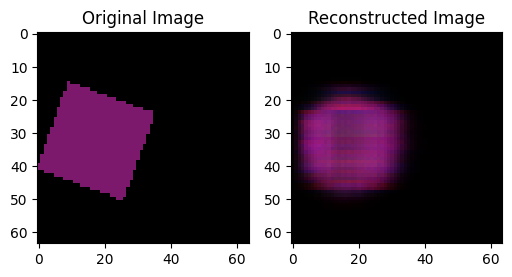

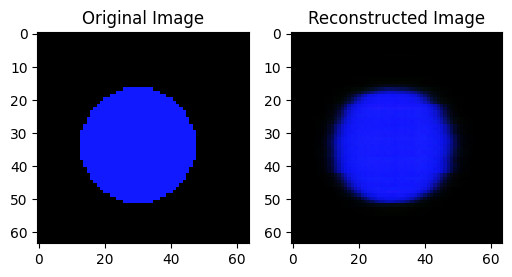

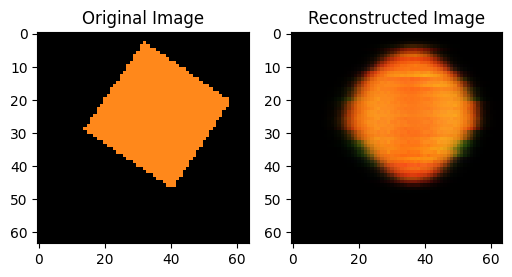

(TransformerAutoencoder(
   (encoder): TransformerEncoder(
     (layers): ModuleList(
       (0-3): 4 x TransformerEncoderLayer(
         (self_attn): MultiheadAttention(
           (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
         )
         (linear1): Linear(in_features=256, out_features=512, bias=True)
         (dropout): Dropout(p=0.2, inplace=False)
         (linear2): Linear(in_features=512, out_features=256, bias=True)
         (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
         (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
         (dropout1): Dropout(p=0.2, inplace=False)
         (dropout2): Dropout(p=0.2, inplace=False)
       )
     )
   )
   (patch_embedding): Linear(in_features=192, out_features=256, bias=True)
   (positional_encoding): PositionalEncoding2D()
   (bottleneck): Linear(in_features=256, out_features=4, bias=True)
   (decoder_input): Linear(in_features=4, out_features=256, bi

In [9]:
train_model(embedding_size=4, dropout_rate=0.2)

Number of parameters: 4316866
Epoch [1/20], Train Loss: 0.2695, Test Loss: 0.1962
Epoch [2/20], Train Loss: 0.1845, Test Loss: 0.1776
Epoch [3/20], Train Loss: 0.1679, Test Loss: 0.1636
Epoch [4/20], Train Loss: 0.1487, Test Loss: 0.1322
Epoch [5/20], Train Loss: 0.1216, Test Loss: 0.1164
Epoch [6/20], Train Loss: 0.1123, Test Loss: 0.1100
Epoch [7/20], Train Loss: 0.1074, Test Loss: 0.1058
Epoch [8/20], Train Loss: 0.1042, Test Loss: 0.1032
Epoch [9/20], Train Loss: 0.1020, Test Loss: 0.1020
Epoch [10/20], Train Loss: 0.1001, Test Loss: 0.0995
Epoch [11/20], Train Loss: 0.0990, Test Loss: 0.0990
Epoch [12/20], Train Loss: 0.0981, Test Loss: 0.0976
Epoch [13/20], Train Loss: 0.0972, Test Loss: 0.0980
Epoch [14/20], Train Loss: 0.0966, Test Loss: 0.0971
Epoch [15/20], Train Loss: 0.0963, Test Loss: 0.0963
Epoch [16/20], Train Loss: 0.0958, Test Loss: 0.0960
Epoch [17/20], Train Loss: 0.0955, Test Loss: 0.0956
Epoch [18/20], Train Loss: 0.0953, Test Loss: 0.0957
Epoch [19/20], Train Loss

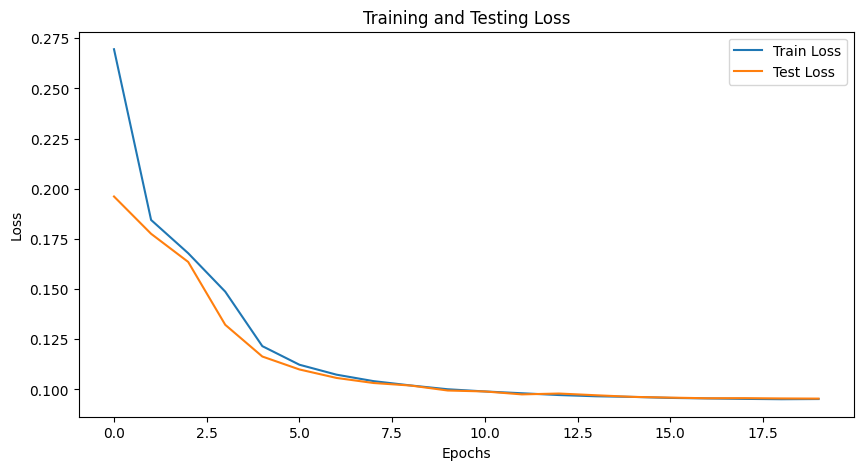

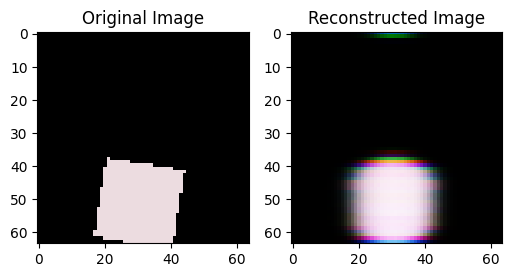

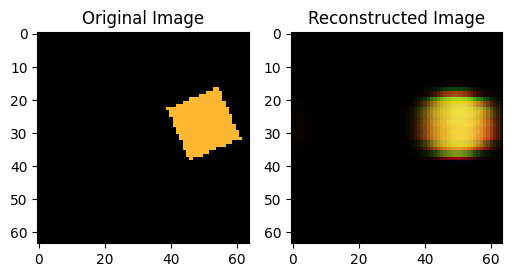

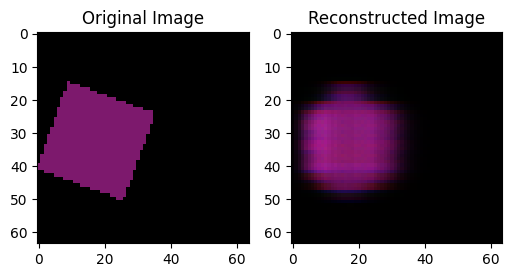

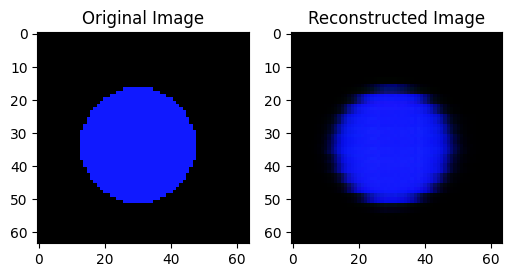

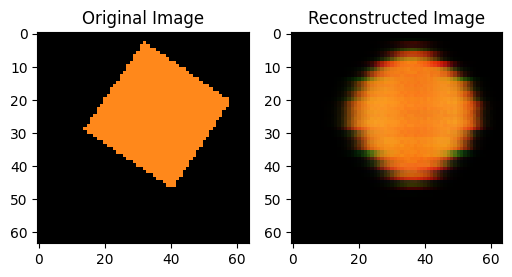

(TransformerAutoencoder(
   (encoder): TransformerEncoder(
     (layers): ModuleList(
       (0-3): 4 x TransformerEncoderLayer(
         (self_attn): MultiheadAttention(
           (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
         )
         (linear1): Linear(in_features=256, out_features=512, bias=True)
         (dropout): Dropout(p=0.1, inplace=False)
         (linear2): Linear(in_features=512, out_features=256, bias=True)
         (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
         (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
         (dropout1): Dropout(p=0.1, inplace=False)
         (dropout2): Dropout(p=0.1, inplace=False)
       )
     )
   )
   (patch_embedding): Linear(in_features=192, out_features=256, bias=True)
   (positional_encoding): PositionalEncoding2D()
   (bottleneck): Linear(in_features=256, out_features=2, bias=True)
   (decoder_input): Linear(in_features=2, out_features=256, bi

In [10]:
train_model(embedding_size=2, dropout_rate=0.1)

Number of parameters: 4317379
Epoch [1/20], Train Loss: 0.2709, Test Loss: 0.1955
Epoch [2/20], Train Loss: 0.1829, Test Loss: 0.1695
Epoch [3/20], Train Loss: 0.1596, Test Loss: 0.1370
Epoch [4/20], Train Loss: 0.1241, Test Loss: 0.1145
Epoch [5/20], Train Loss: 0.1112, Test Loss: 0.1083
Epoch [6/20], Train Loss: 0.1055, Test Loss: 0.1044
Epoch [7/20], Train Loss: 0.1020, Test Loss: 0.1001
Epoch [8/20], Train Loss: 0.0991, Test Loss: 0.0989
Epoch [9/20], Train Loss: 0.0973, Test Loss: 0.0993
Epoch [10/20], Train Loss: 0.0961, Test Loss: 0.0954
Epoch [11/20], Train Loss: 0.0947, Test Loss: 0.0942
Epoch [12/20], Train Loss: 0.0938, Test Loss: 0.0934
Epoch [13/20], Train Loss: 0.0932, Test Loss: 0.0934
Epoch [14/20], Train Loss: 0.0926, Test Loss: 0.0925
Epoch [15/20], Train Loss: 0.0921, Test Loss: 0.0919
Epoch [16/20], Train Loss: 0.0918, Test Loss: 0.0920
Epoch [17/20], Train Loss: 0.0915, Test Loss: 0.0916
Epoch [18/20], Train Loss: 0.0913, Test Loss: 0.0913
Epoch [19/20], Train Loss

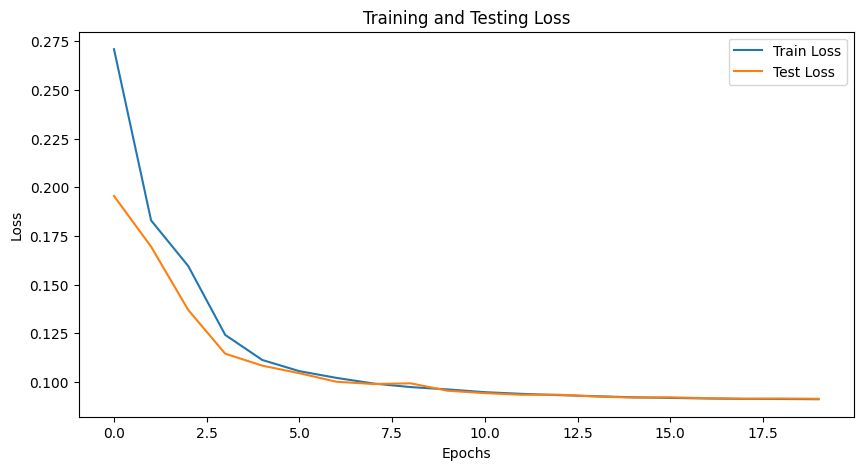

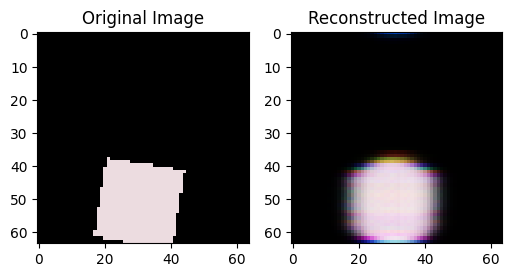

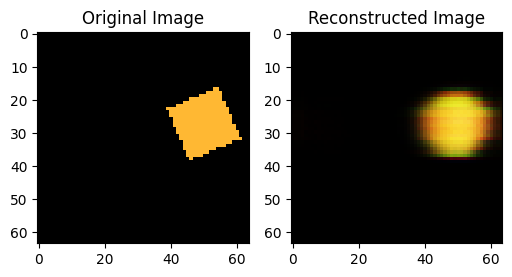

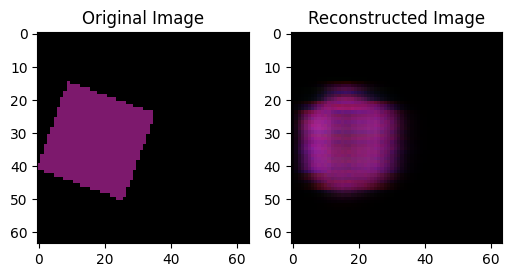

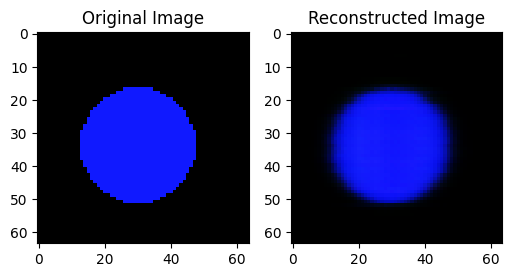

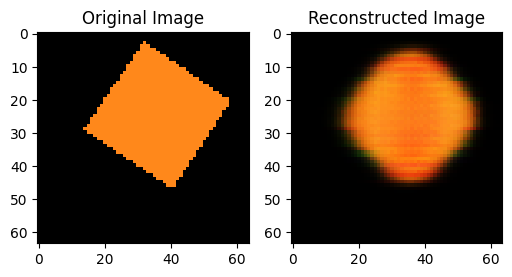

(TransformerAutoencoder(
   (encoder): TransformerEncoder(
     (layers): ModuleList(
       (0-3): 4 x TransformerEncoderLayer(
         (self_attn): MultiheadAttention(
           (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
         )
         (linear1): Linear(in_features=256, out_features=512, bias=True)
         (dropout): Dropout(p=0.1, inplace=False)
         (linear2): Linear(in_features=512, out_features=256, bias=True)
         (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
         (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
         (dropout1): Dropout(p=0.1, inplace=False)
         (dropout2): Dropout(p=0.1, inplace=False)
       )
     )
   )
   (patch_embedding): Linear(in_features=192, out_features=256, bias=True)
   (positional_encoding): PositionalEncoding2D()
   (bottleneck): Linear(in_features=256, out_features=3, bias=True)
   (decoder_input): Linear(in_features=3, out_features=256, bi

In [11]:
train_model(embedding_size=3, dropout_rate=0.1)

Number of parameters: 4319944
Epoch [1/20], Train Loss: 0.2730, Test Loss: 0.1988
Epoch [2/20], Train Loss: 0.1808, Test Loss: 0.1686
Epoch [3/20], Train Loss: 0.1639, Test Loss: 0.1623
Epoch [4/20], Train Loss: 0.1379, Test Loss: 0.1244
Epoch [5/20], Train Loss: 0.1147, Test Loss: 0.1099
Epoch [6/20], Train Loss: 0.1065, Test Loss: 0.1040
Epoch [7/20], Train Loss: 0.1018, Test Loss: 0.1011
Epoch [8/20], Train Loss: 0.0991, Test Loss: 0.0984
Epoch [9/20], Train Loss: 0.0968, Test Loss: 0.0964
Epoch [10/20], Train Loss: 0.0953, Test Loss: 0.0952
Epoch [11/20], Train Loss: 0.0944, Test Loss: 0.0938
Epoch [12/20], Train Loss: 0.0932, Test Loss: 0.0927
Epoch [13/20], Train Loss: 0.0924, Test Loss: 0.0921
Epoch [14/20], Train Loss: 0.0916, Test Loss: 0.0914
Epoch [15/20], Train Loss: 0.0912, Test Loss: 0.0911
Epoch [16/20], Train Loss: 0.0908, Test Loss: 0.0907
Epoch [17/20], Train Loss: 0.0904, Test Loss: 0.0905
Epoch [18/20], Train Loss: 0.0902, Test Loss: 0.0902
Epoch [19/20], Train Loss

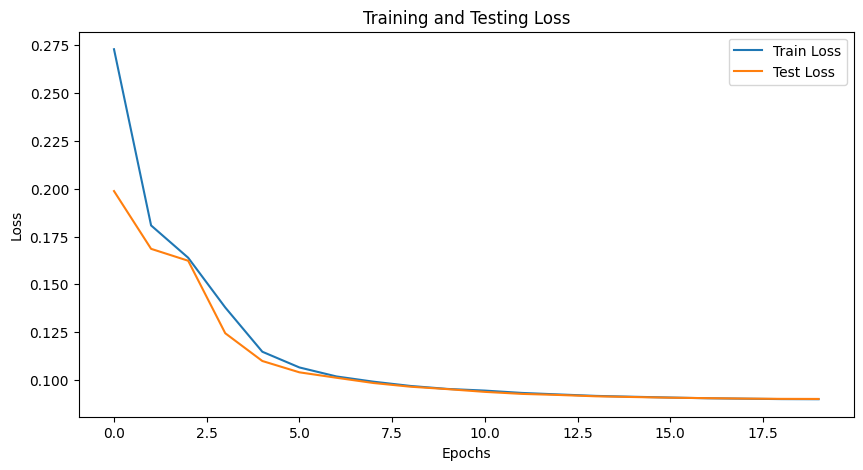

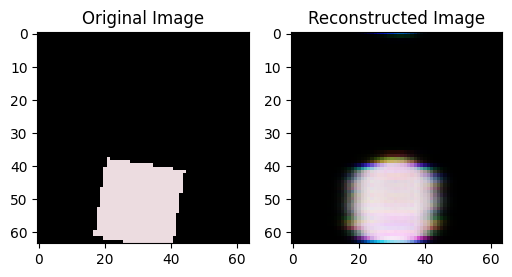

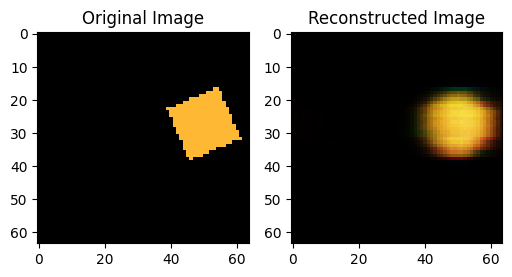

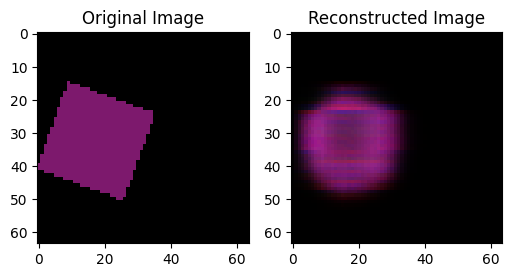

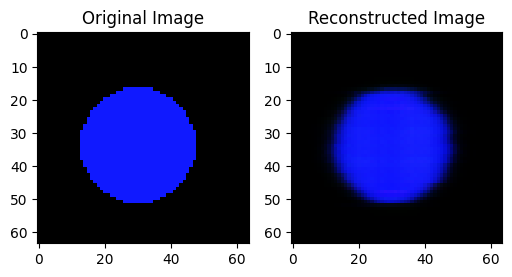

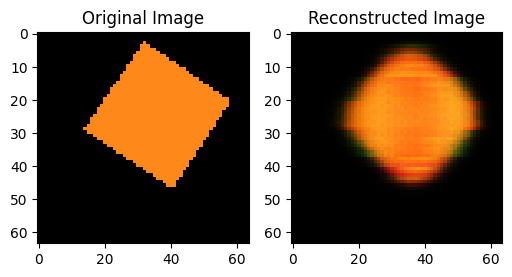

(TransformerAutoencoder(
   (encoder): TransformerEncoder(
     (layers): ModuleList(
       (0-3): 4 x TransformerEncoderLayer(
         (self_attn): MultiheadAttention(
           (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
         )
         (linear1): Linear(in_features=256, out_features=512, bias=True)
         (dropout): Dropout(p=0.1, inplace=False)
         (linear2): Linear(in_features=512, out_features=256, bias=True)
         (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
         (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
         (dropout1): Dropout(p=0.1, inplace=False)
         (dropout2): Dropout(p=0.1, inplace=False)
       )
     )
   )
   (patch_embedding): Linear(in_features=192, out_features=256, bias=True)
   (positional_encoding): PositionalEncoding2D()
   (bottleneck): Linear(in_features=256, out_features=8, bias=True)
   (decoder_input): Linear(in_features=8, out_features=256, bi

In [5]:
train_model(embedding_size=8, dropout_rate=0.1)

Number of parameters: 4324048
Epoch [1/20], Train Loss: 0.2771, Test Loss: 0.1998
Epoch [2/20], Train Loss: 0.1847, Test Loss: 0.1709
Epoch [3/20], Train Loss: 0.1510, Test Loss: 0.1308
Epoch [4/20], Train Loss: 0.1223, Test Loss: 0.1158
Epoch [5/20], Train Loss: 0.1124, Test Loss: 0.1148
Epoch [6/20], Train Loss: 0.1064, Test Loss: 0.1037
Epoch [7/20], Train Loss: 0.1026, Test Loss: 0.1006
Epoch [8/20], Train Loss: 0.0998, Test Loss: 0.0992
Epoch [9/20], Train Loss: 0.0979, Test Loss: 0.0976
Epoch [10/20], Train Loss: 0.0964, Test Loss: 0.0959
Epoch [11/20], Train Loss: 0.0954, Test Loss: 0.0952
Epoch [12/20], Train Loss: 0.0942, Test Loss: 0.0939
Epoch [13/20], Train Loss: 0.0936, Test Loss: 0.0933
Epoch [14/20], Train Loss: 0.0929, Test Loss: 0.0924
Epoch [15/20], Train Loss: 0.0923, Test Loss: 0.0921
Epoch [16/20], Train Loss: 0.0919, Test Loss: 0.0919
Epoch [17/20], Train Loss: 0.0915, Test Loss: 0.0916
Epoch [18/20], Train Loss: 0.0914, Test Loss: 0.0914
Epoch [19/20], Train Loss

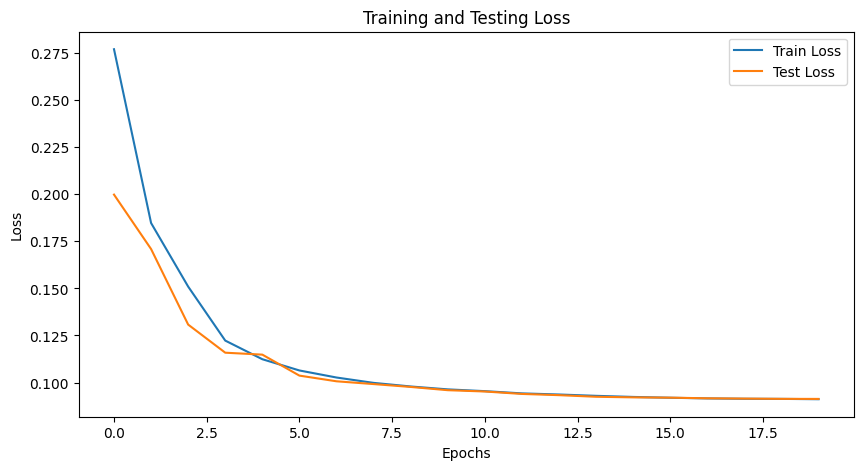

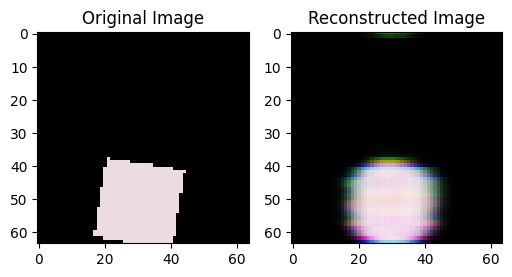

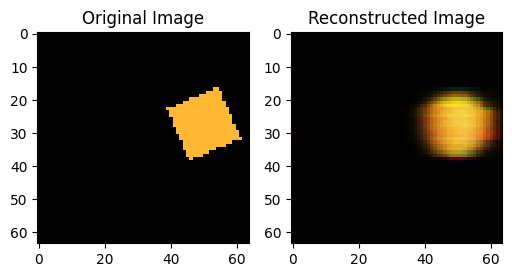

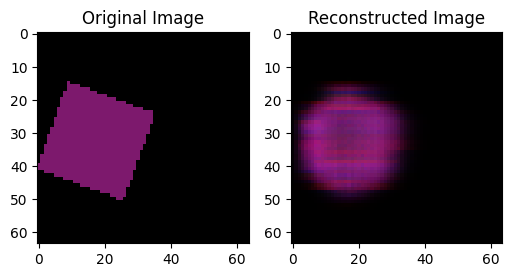

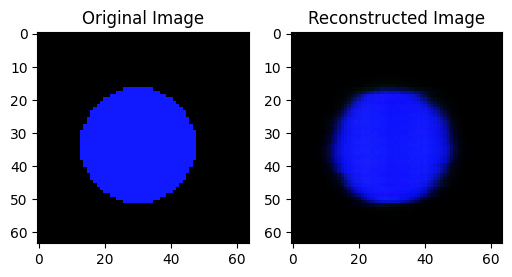

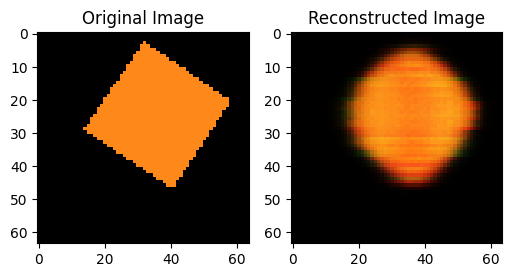

(TransformerAutoencoder(
   (encoder): TransformerEncoder(
     (layers): ModuleList(
       (0-3): 4 x TransformerEncoderLayer(
         (self_attn): MultiheadAttention(
           (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
         )
         (linear1): Linear(in_features=256, out_features=512, bias=True)
         (dropout): Dropout(p=0.1, inplace=False)
         (linear2): Linear(in_features=512, out_features=256, bias=True)
         (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
         (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
         (dropout1): Dropout(p=0.1, inplace=False)
         (dropout2): Dropout(p=0.1, inplace=False)
       )
     )
   )
   (patch_embedding): Linear(in_features=192, out_features=256, bias=True)
   (positional_encoding): PositionalEncoding2D()
   (bottleneck): Linear(in_features=256, out_features=16, bias=True)
   (decoder_input): Linear(in_features=16, out_features=256, 

In [6]:
train_model(embedding_size=16, dropout_rate=0.1)

Number of parameters: 4332256
Epoch [1/20], Train Loss: 0.2722, Test Loss: 0.1973
Epoch [2/20], Train Loss: 0.1817, Test Loss: 0.1702
Epoch [3/20], Train Loss: 0.1429, Test Loss: 0.1239
Epoch [4/20], Train Loss: 0.1165, Test Loss: 0.1116
Epoch [5/20], Train Loss: 0.1075, Test Loss: 0.1063
Epoch [6/20], Train Loss: 0.1026, Test Loss: 0.1005
Epoch [7/20], Train Loss: 0.0995, Test Loss: 0.0984
Epoch [8/20], Train Loss: 0.0967, Test Loss: 0.0960
Epoch [9/20], Train Loss: 0.0948, Test Loss: 0.0946
Epoch [10/20], Train Loss: 0.0934, Test Loss: 0.0928
Epoch [11/20], Train Loss: 0.0922, Test Loss: 0.0920
Epoch [12/20], Train Loss: 0.0913, Test Loss: 0.0913
Epoch [13/20], Train Loss: 0.0904, Test Loss: 0.0903
Epoch [14/20], Train Loss: 0.0898, Test Loss: 0.0899
Epoch [15/20], Train Loss: 0.0892, Test Loss: 0.0894
Epoch [16/20], Train Loss: 0.0888, Test Loss: 0.0891
Epoch [17/20], Train Loss: 0.0886, Test Loss: 0.0888
Epoch [18/20], Train Loss: 0.0883, Test Loss: 0.0887
Epoch [19/20], Train Loss

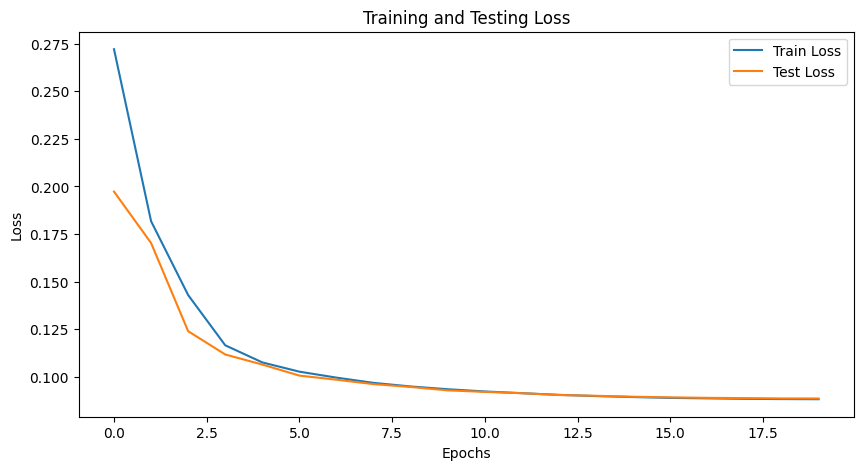

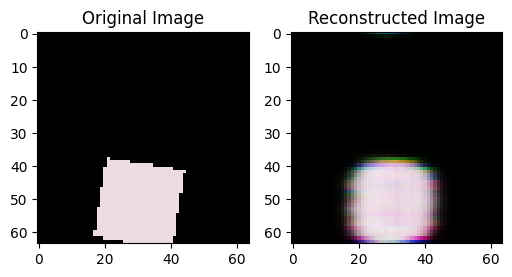

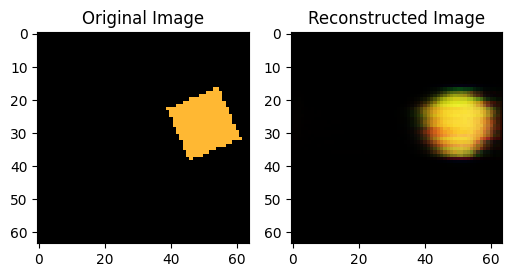

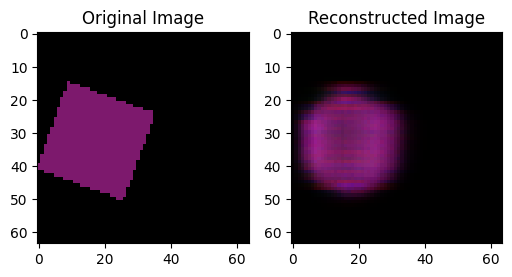

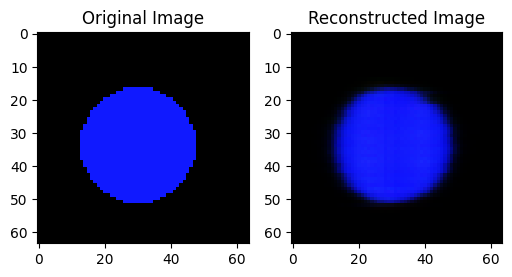

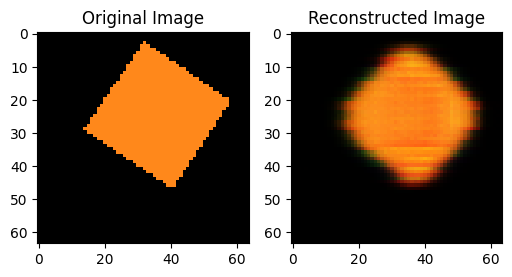

(TransformerAutoencoder(
   (encoder): TransformerEncoder(
     (layers): ModuleList(
       (0-3): 4 x TransformerEncoderLayer(
         (self_attn): MultiheadAttention(
           (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
         )
         (linear1): Linear(in_features=256, out_features=512, bias=True)
         (dropout): Dropout(p=0.1, inplace=False)
         (linear2): Linear(in_features=512, out_features=256, bias=True)
         (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
         (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
         (dropout1): Dropout(p=0.1, inplace=False)
         (dropout2): Dropout(p=0.1, inplace=False)
       )
     )
   )
   (patch_embedding): Linear(in_features=192, out_features=256, bias=True)
   (positional_encoding): PositionalEncoding2D()
   (bottleneck): Linear(in_features=256, out_features=32, bias=True)
   (decoder_input): Linear(in_features=32, out_features=256, 

In [7]:
train_model(embedding_size=32, dropout_rate=0.1)

Number of parameters: 4348672
Epoch [1/20], Train Loss: 0.2732, Test Loss: 0.1955
Epoch [2/20], Train Loss: 0.1825, Test Loss: 0.1695
Epoch [3/20], Train Loss: 0.1474, Test Loss: 0.1269
Epoch [4/20], Train Loss: 0.1179, Test Loss: 0.1107
Epoch [5/20], Train Loss: 0.1082, Test Loss: 0.1047
Epoch [6/20], Train Loss: 0.1030, Test Loss: 0.1008
Epoch [7/20], Train Loss: 0.0996, Test Loss: 0.0983
Epoch [8/20], Train Loss: 0.0972, Test Loss: 0.0973
Epoch [9/20], Train Loss: 0.0954, Test Loss: 0.0955
Epoch [10/20], Train Loss: 0.0940, Test Loss: 0.0944
Epoch [11/20], Train Loss: 0.0927, Test Loss: 0.0928
Epoch [12/20], Train Loss: 0.0916, Test Loss: 0.0908
Epoch [13/20], Train Loss: 0.0905, Test Loss: 0.0903
Epoch [14/20], Train Loss: 0.0897, Test Loss: 0.0894
Epoch [15/20], Train Loss: 0.0891, Test Loss: 0.0890
Epoch [16/20], Train Loss: 0.0886, Test Loss: 0.0886
Epoch [17/20], Train Loss: 0.0882, Test Loss: 0.0882
Epoch [18/20], Train Loss: 0.0879, Test Loss: 0.0881
Epoch [19/20], Train Loss

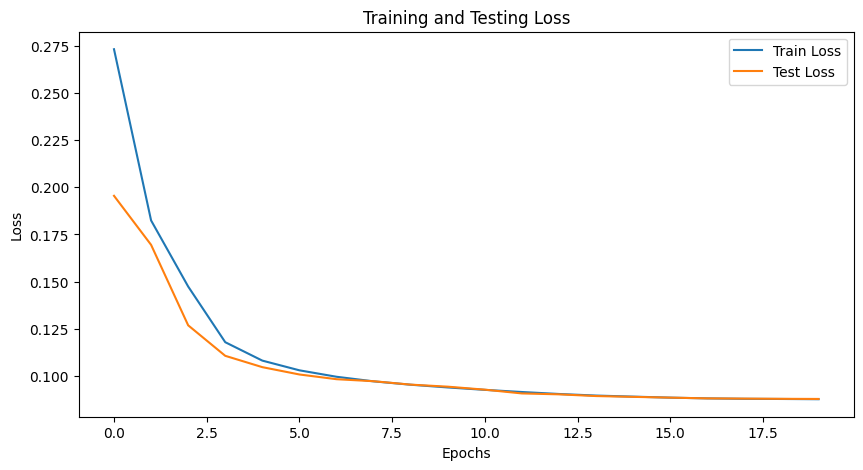

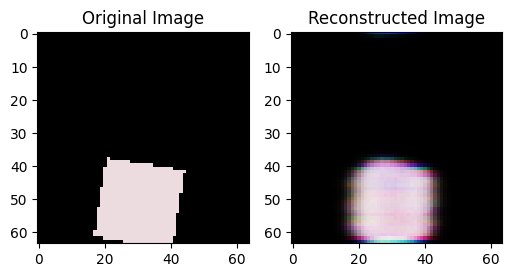

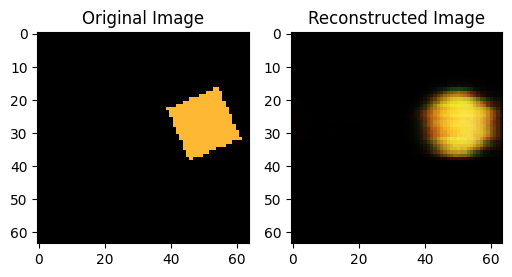

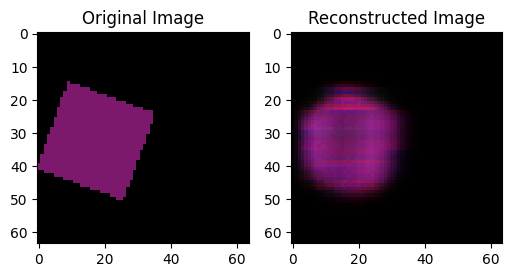

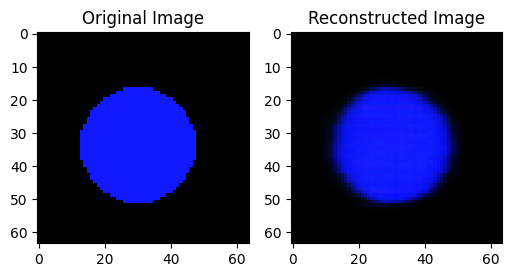

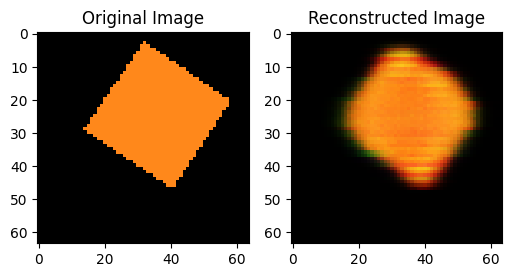

(TransformerAutoencoder(
   (encoder): TransformerEncoder(
     (layers): ModuleList(
       (0-3): 4 x TransformerEncoderLayer(
         (self_attn): MultiheadAttention(
           (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
         )
         (linear1): Linear(in_features=256, out_features=512, bias=True)
         (dropout): Dropout(p=0.1, inplace=False)
         (linear2): Linear(in_features=512, out_features=256, bias=True)
         (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
         (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
         (dropout1): Dropout(p=0.1, inplace=False)
         (dropout2): Dropout(p=0.1, inplace=False)
       )
     )
   )
   (patch_embedding): Linear(in_features=192, out_features=256, bias=True)
   (positional_encoding): PositionalEncoding2D()
   (bottleneck): Linear(in_features=256, out_features=64, bias=True)
   (decoder_input): Linear(in_features=64, out_features=256, 

In [8]:
train_model(embedding_size=64, dropout_rate=0.1)